In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def canny_edge_detection(input_path, lower_thresh=100, upper_thresh=200):
    # Read the image in grayscale
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    # Apply Canny edge detection
    edges = cv2.Canny(img, lower_thresh, upper_thresh)

    return edges

In [3]:
def hough_line_detection(input_path, canny_low=150, canny_high=450, hough_thresh=100, min_len=50, max_gap=10):
    # Read the original image (for displaying lines)
    img = cv2.imread(input_path)
    if img is None:
        raise ValueError("Image not found or invalid image path.")

    # Get edges using Canny
    edges = canny_edge_detection(input_path, canny_low, canny_high)

    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(edges, 
                            rho=1,            # Distance resolution of accumulator in pixels
                            theta=np.pi / 180, # Angle resolution of accumulator in radians
                            threshold=hough_thresh, # Minimum number of votes (intersections in Hough grid cell)
                            minLineLength=min_len,  # Minimum length of line (pixels)
                            maxLineGap=max_gap)     # Maximum allowed gap between points on the same line

    # Draw the lines on a copy of the original image
    line_img = img.copy()

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines with thickness=2
    else:
        print("No lines detected!")

    return line_img, lines

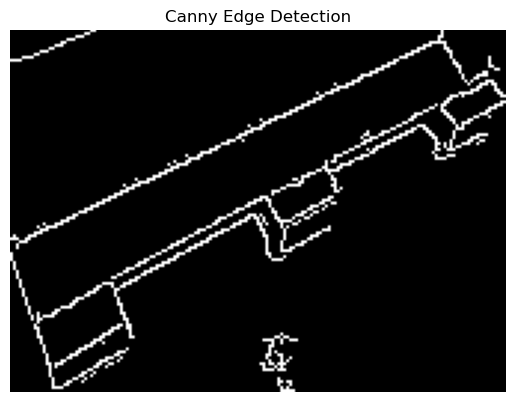

In [108]:
input_image = r"C:\Users\chena\Desktop\EZLift\src\raspberry_pi\notebooks\test_pallet_43_256_cropped.jpg"
edges = canny_edge_detection(input_image, lower_thresh=150, upper_thresh=450)

# Display the result using matplotlib
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()

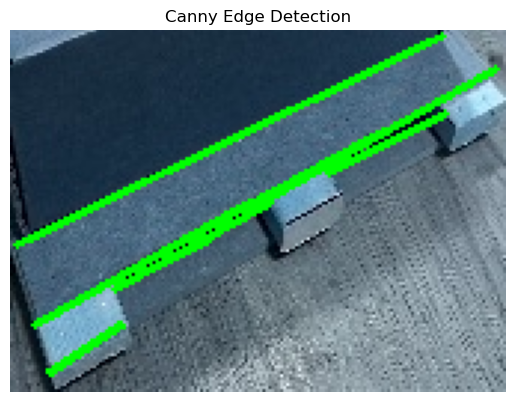

In [112]:
input_image = r"C:\Users\chena\Desktop\EZLift\src\raspberry_pi\notebooks\test_pallet_43_256_cropped.jpg"
line_img, lines = hough_line_detection(input_image, canny_low=150, canny_high=450, hough_thresh=45, min_len=20, max_gap=7)

# Display the result using matplotlib
plt.imshow(line_img)
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()

In [117]:
def get_angle(lines):
    lines_polar = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dx = x2 - x1
        dy = y2 - y1
        angle_rad = math.atan2(-dy, dx)
        angle_deg = math.degrees(angle_rad)
        angle_deg = (angle_deg + 360) % 360
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        lines_polar.append((angle_deg, length))

    lines_polar = sorted(lines_polar, key=lambda x: x[0])
    groups = []
    current_group = [lines_polar[0]]

    for angle, length in lines_polar[1:]:
        if abs(angle - current_group[-1][0]) < 2:
            current_group.append((angle, length))
        else:
            groups.append(current_group)
            current_group = [(angle, length)]
    groups.append(current_group)

    best_metric = 0
    best_angle = None
    for group in groups:
        avg_length = np.mean([length for _, length in group])
        if len(group) * avg_length**1.5 > best_metric:
            best_metric = len(group) * avg_length**1.5
            best_angle = np.mean([angle for angle, _ in group])

    return best_angle
